## Step 3 - Climate Analysis and Exploration

In [1]:
# Import SQLAlchemy `automap` and other dependencies here
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect
from sqlalchemy import desc
from sqlalchemy import func

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Create an engine for the `hawaii.sqlite` database
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# Use automap_base() to reflect hawaii.sqlite DB tables into classes
Base = automap_base()
Base.prepare(engine, reflect = True)
session = Session(bind=engine)
Base.classes.keys()

['Measurements', 'Stations']

In [4]:
# save a reference to the classes
Measurement = Base.classes.Measurements
Station = Base.classes.Stations

In [5]:
# get date range for last 12 months of data
# start date
start_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()
start_date = np.ravel(start_date)[0]
# end_date
records = session.query(Measurement.date, func.avg(Measurement.prcp))\
          .group_by(func.strftime('%Y-%m', Measurement.date))\
          .order_by(Measurement.date.desc()).limit(12).all()
end_date = np.ravel(records[11])[0]
print(f'Start Date: {start_date} End Date: {end_date}')

Start Date: 2017-08-23 End Date: 2016-09-30


## 1) Precipitation Analysis

In [6]:
# retrieve the last 12 months of precipitation data
precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date.between(end_date, start_date)).all()

In [7]:
# load the results into a Dataframe
precipitation_df = pd.DataFrame.from_records(precipitation)
precipitation_df = precipitation_df.rename(columns={0: 'Date', 1: 'Precipitation'})
# Set the index to the Date column
precipitation_df = precipitation_df.set_index('Date')
print(precipitation_df.count())
precipitation_df.head()

Precipitation    1801
dtype: int64


,Precipitation
Date,
2016-09-30,0.0
2016-10-01,0.0
2016-10-02,0.0
2016-10-03,0.0
2016-10-04,0.0


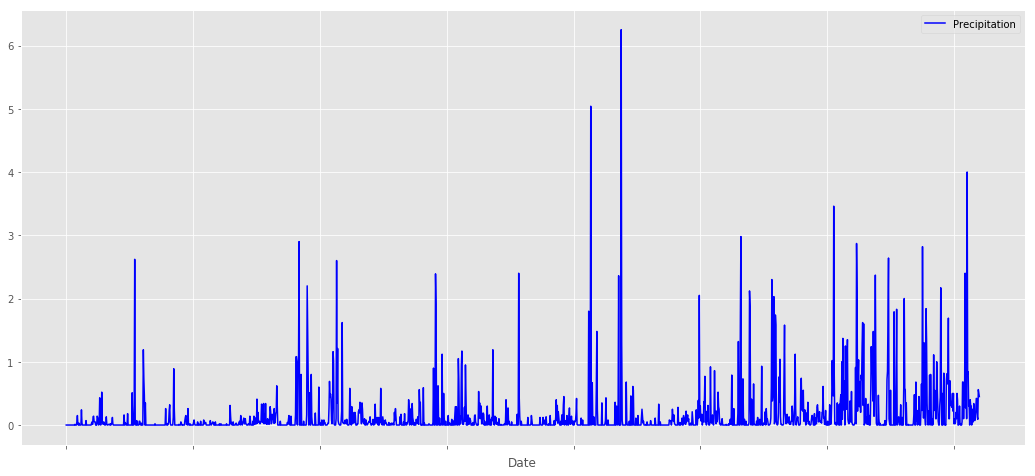

In [8]:
# Plot the results using the DataFrame
plt.style.use('ggplot')
precipitation_df.plot(figsize = (18,8), color = 'blue', rot = 340)
plt.show()

In [9]:
# summary statistics for the precipitation data
precipitation_df["Precipitation"].describe()

count    1801.000000
mean        0.160589
std         0.424107
min         0.000000
25%         0.000000
50%         0.010000
75%         0.120000
max         6.250000
Name: Precipitation, dtype: float64

## 2) Station Analysis

In [10]:
# query to calculate the total number of stations
stations_count = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).count()
stations_count

9

In [11]:
# query to find the most active stations
active_stations = session.query(Measurement.station, func.count(Measurement.tobs).label('Observations'))\
                  .group_by(Measurement.station).order_by(desc(func.count(Measurement.tobs))).all()
    
# List the stations and observation counts in descending order
active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [12]:
# station that has the highest number of observations
most_active = np.ravel(active_stations)[0]
most_active

'USC00519281'

In [13]:
# Filter by the station with the highest number of observations
observation_data = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
filter(Measurement.date.between(end_date, start_date)).\
filter(Measurement.station == most_active).all()

In [14]:
# load the results into a dataframe
observation_df = pd.DataFrame.from_records(observation_data)
observation_df = observation_df.rename(columns={0: 'Station', 1: 'Date', 2:'Observations'})
print(observation_df.count())
observation_df.head()

Station         314
Date            314
Observations    314
dtype: int64


,Station,Date,Observations
0,USC00519281,2016-09-30,78
1,USC00519281,2016-10-01,77
2,USC00519281,2016-10-02,79
3,USC00519281,2016-10-03,79
4,USC00519281,2016-10-04,79


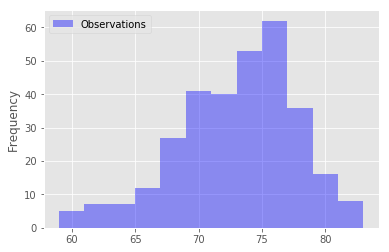

In [15]:
# Plot the results as a histogram with bins=12
observation_df.plot.hist(by=observation_df.Observations, bins=12, color='blue', alpha = 0.4)
plt.ylabel("Frequency")
plt.show()

## 3) Temperature Analysis

In [16]:
# define calc_temps to calculate and return min, avg, max temp for a specified range of dates
def calc_temps(start_date, end_date):
    records = session.query(func.max(Measurement.tobs).label('max_temp'), func.avg(Measurement.tobs).label('avg_temp')\
                                ,func.min(Measurement.tobs).label('min_temp'))\
                  .filter(Measurement.date.between(end_date, start_date)).all()
    return records

In [17]:
records = calc_temps(start_date, end_date)
temperature_df = pd.DataFrame.from_records(records)
temperature_df = temperature_df.rename(columns={0: 'Max. Temp.', 1: 'Avg. Temp.', 2:'Min. Temp.'})
temperature_df

,Max. Temp.,Avg. Temp.,Min. Temp.
0,87,74.099944,58


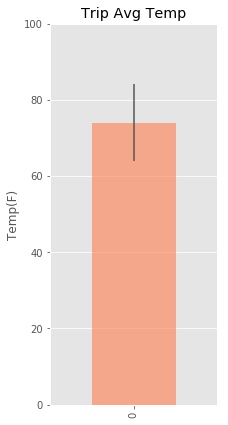

In [18]:
# Plot the min, avg, and max temperature from your previous query as a bar chart
mean = temperature_df["Avg. Temp."]
err = (temperature_df["Max. Temp."] - temperature_df["Min. Temp."] ) * 0.35

# Set Graph Properties
fig, ax = plt.subplots()
mean.plot.bar(yerr=err, color='coral', width=0.5, ax=ax, figsize=(3,7), alpha=0.6)
plt.ylabel('Temp(F)')
plt.title("Trip Avg Temp")

plt.grid(False, axis='x')
plt.ylim(0,100)
# Save the figure
plt.savefig("Trip_Avg_Temp.png")
# Show Plot
plt.show()

## Step 4 - Climate App

In [19]:
# 1. import Flask
from flask import Flask, jsonify
# 2. Flask Setup - create an app, being sure to pass __name__
app = Flask(__name__)

In [20]:
# Complete the routes for your app here
# 3. Define what to do when a user hits the index route
@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/><br/>"
        f"/api/v1.0/precipitation - Precipitation<br/>"

        f"/api/v1.0/stations"
        f"- List of stations from the dataset<br/>"

        f"/api/v1.0/tobs"
        f"- Temperature Observations (tobs) for the previous year<br/>"

        f"/api/v1.0/&ltstart&gt"
        f"- Calculates MIN, AVG, and MAX temp. for all dates greater than and equal to the start date<br/>"

        f"/api/v1.0/&ltstart&gt/&ltend&gt"
        f"- Calculates MIN, AVG, and MAX temp. for a given start or start-end range<br/>"
    )

In [21]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    # prec_df = observation_df[["Date", "Observations"]]
    # prec_df = prec_df.set_index("Date")
    # return jsonify(prec_df.to_dict())
    return jsonify(precipitation_df.to_dict())

In [22]:
@app.route("/api/v1.0/stations")
def stations():
    records = session.query(Station.station, Station.name).all()
    station_df = pd.DataFrame.from_records(records)
    station_df = station_df.rename(columns={0: 'Station', 1: 'Name'})
    return jsonify(station_df.to_dict())

In [23]:
@app.route("/api/v1.0/tobs")
def tobs():
    tobs_df = observation_df[["Date", "Observations"]]
    tobs_df = tobs_df.set_index("Date")
    return jsonify(tobs_df.to_dict())

In [24]:
def calc_temp_s(start_date):
    records = session.query(func.max(Measurement.tobs).label('max_temp'), func.avg(Measurement.tobs).label('avg_temp')\
                                ,func.min(Measurement.tobs).label('min_temp'))\
                  .filter(Measurement.date >= start_date).all()    
    return records[0]

In [25]:
@app.route("/api/v1.0/<start>")
def temp(start):
    max_tmp, avg_tmp, min_tmp = calc_temp_s(start)
    temp_dict = {"Max. Temp.": max_tmp,
                 "Avg. Temp.": avg_tmp,
                 "Min. Temp.": min_tmp}
    return jsonify(temp_dict)

In [26]:
@app.route("/api/v1.0/<start>/<end>")
def calc_temp_se(start, end):
    if datetime.strptime(start, '%Y-%m-%d') > datetime.strptime(end, '%Y-%m-%d'):
        records = calc_temps(start, end)
        max_tmp, avg_tmp, min_tmp = records[0]
        temp_dict = {"Max. Temp.": max_tmp,
                 "Avg. Temp.": avg_tmp,
                 "Min. Temp.": min_tmp}
        return jsonify(temp_dict)
    else:
        return "Please make sure Start Date is always greater than End Date."

In [27]:
# Create your app.run statement here
if __name__ == '__main__':
    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [06/Feb/2018 22:52:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2018 22:52:30] "GET /api/v1.0/2012-01-01 HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2018 22:52:46] "GET /api/v1.0/2012-01-01/2017-01-01 HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2018 22:52:59] "GET /api/v1.0/2017-01-01/2012-01-01 HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2018 22:53:04] "GET /api/v1.0/2012-01-01/2017-01-01 HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2018 22:53:05] "GET /api/v1.0/2012-01-01 HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2018 22:53:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2018 22:53:19] "GET /api/v1.0/tobs HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2018 22:53:22] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2018 22:53:33] "GET /api/v1.0/stations HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2018 22:53:36] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Feb/2018 22:53:45] "GET /api/v1.0/precipitation HTTP/1.1" 200 -
